In [20]:
from keras.models import Sequential
from keras import layers
import numpy as np
from six.moves import range
import csv
import matplotlib.pyplot as plt

# Parameters Config

In [2]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [3]:
TRAINING_SIZE = 80000
DIGITS = 3
REVERSE = False
MAXLEN = DIGITS + 1 + DIGITS
chars = '0123456789- '
RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

In [4]:
class CharacterTable(object):
    def __init__(self, chars):
        self.chars = sorted(set(chars)) # [' ', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars)) # {' ': 0, '-': 1, '0': 2, ... , '9': 11}
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars)) # {0: ' ', 1: '-', 2: '0',..., 11: '9'}
    
    def encode(self, C, num_rows):
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x
    
    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return "".join(self.indices_char[i] for i in x)

In [5]:
ctable = CharacterTable(chars)

# Data Generation

In [6]:
questions = []
expected = []
seen = set()
print('Generating data...')
while len(questions) < TRAINING_SIZE:
    # f函數：隨機產生一個1位數到3位數之間的整數（DIGIT==3）
    f = lambda: int(''.join(np.random.choice(list('0123456789')) for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    key = tuple(sorted((a, b), reverse=True)) # 將a, b由小到大排序並轉成tuple
    a, b = key[0], key[1]
    if key in seen:
        continue
    seen.add(key)
    q = '{}-{}'.format(a, b)
    query = q + ' ' * (MAXLEN - len(q)) # 將query長度補足到7，MAXLEN最長等於7(當DIGIT等於3)
    ans = str(a - b)
    ans += ' ' * (DIGITS - len(ans)) # 將ans長度補足到3，兩個三位數相減最多是三位數
    if REVERSE:
        query = query[::-1]
    questions.append(query)
    expected.append(ans)
print('Total addition questions:', len(questions))

Generating data...
Total addition questions: 80000


In [7]:
print(questions[:5], expected[:5])

['130-4  ', '849-6  ', '759-61 ', '85-67  ', '17-12  '] ['126', '843', '698', '18 ', '5  ']


# Processing

In [8]:
print('Vectorization...')
# x總共有80000筆資料，每筆資料shape是7x12，7代表問題長度為7，並且每個位數的值有12種可能
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool) # x.shape = (80000, 7, 12)
y = np.zeros((len(expected), DIGITS, len(chars)), dtype=np.bool) # y.shape = (80000, 3, 12)

# 將問題與解答編碼成一個一個的二維陣列
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS)

Vectorization...


In [9]:
# 將80000筆資料打亂順序
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# train_test_split
train_x = x[:60000]
train_y = y[:60000]
test_x = x[60000:]
test_y = y[60000:]

split_at = len(train_x) - len(train_x) // 10
(x_train, x_val) = train_x[:split_at], train_x[split_at:]
(y_train, y_val) = train_y[:split_at], train_y[split_at:]

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

print('Testing Data:')
print(test_x.shape)
print(test_y.shape)

Training Data:
(54000, 7, 12)
(54000, 3, 12)
Validation Data:
(6000, 7, 12)
(6000, 3, 12)
Testing Data:
(20000, 7, 12)
(20000, 3, 12)


# Build Model

https://blog.csdn.net/ChaoFeiLi/article/details/89323078

In [10]:
def buildOneToOneModel(shape):
    model = Sequential()
    model.add(layers.LSTM(128, input_shape=(shape[1], shape[2])))
    model.add(layers.RepeatVector(3))
    model.add(layers.LSTM(64, return_sequences=True))
    model.add(layers.LSTM(64, return_sequences=True))
    model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))
    model.compile(loss="mse", optimizer="adam", metrics=['accuracy'])
    model.summary()
    return model

In [11]:
print('Build model...')
model = buildOneToOneModel(x_train.shape)
#model.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_val, y_val))

Build model...
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               72192     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 3, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 3, 64)             49408     
_________________________________________________________________
lstm_3 (LSTM)                (None, 3, 64)             33024     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 3, 12)             780       
Total params: 155,404
Trainable params: 155,404
Non-trainable params: 0
_________________________________________________________________


# Training

In [12]:
decode_y = []
for i in range(20000):
    decode_y.append(ctable.decode(test_y[i]))

In [13]:
epoch_prediction = []
def first_ten():
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model.predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)
        
for iteration in range(100):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=1,
              validation_data=(x_val, y_val))
    if iteration == 0:
        first_ten()
    pred = model.predict(test_x)
    correct = 0
    for i in range(20000):
        if ctable.decode(pred[i]) == decode_y[i]:
            correct += 1
    acc = round(correct/20000, 3)
    print('Accuracy on Testing Data:',acc)
    epoch_prediction.append(acc)
    if acc >= 0.95:
        first_ten()
        break


--------------------------------------------------
Iteration 0
Instructions for updating:
Use tf.cast instead.
Train on 54000 samples, validate on 6000 samples
Epoch 1/1
54000/54000 [==============================] - 40s 732us/step - loss: 0.0740 - acc: 0.1445 - val_loss: 0.0705 - val_acc: 0.1977
Q 590-560 T 30  ☒ 11 
Q 932-787 T 145 ☒ 311
Q 587-9   T 578 ☒ 671
Q 554-31  T 523 ☒ 436
Q 348-14  T 334 ☒ 333
Q 95-13   T 82  ☒ 11 
Q 122-0   T 122 ☒ 11 
Q 861-70  T 791 ☒ 667
Q 644-11  T 633 ☒ 433
Q 781-58  T 723 ☒ 661
Accuracy on Testing Data: 0.003

--------------------------------------------------
Iteration 1
Train on 54000 samples, validate on 6000 samples
Epoch 1/1
54000/54000 [==============================] - 32s 587us/step - loss: 0.0660 - acc: 0.2696 - val_loss: 0.0621 - val_acc: 0.3133
Accuracy on Testing Data: 0.008

--------------------------------------------------
Iteration 2
Train on 54000 samples, validate on 6000 samples
Epoch 1/1
54000/54000 [==============================

Accuracy on Testing Data: 0.087

--------------------------------------------------
Iteration 27
Train on 54000 samples, validate on 6000 samples
Epoch 1/1
54000/54000 [==============================] - 40s 740us/step - loss: 0.0331 - acc: 0.6418 - val_loss: 0.0335 - val_acc: 0.6318
Accuracy on Testing Data: 0.089

--------------------------------------------------
Iteration 28
Train on 54000 samples, validate on 6000 samples
Epoch 1/1
54000/54000 [==============================] - 44s 816us/step - loss: 0.0329 - acc: 0.6437 - val_loss: 0.0333 - val_acc: 0.6362
Accuracy on Testing Data: 0.089

--------------------------------------------------
Iteration 29
Train on 54000 samples, validate on 6000 samples
Epoch 1/1
54000/54000 [==============================] - 45s 840us/step - loss: 0.0328 - acc: 0.6460 - val_loss: 0.0322 - val_acc: 0.6462
Accuracy on Testing Data: 0.1

--------------------------------------------------
Iteration 30
Train on 54000 samples, validate on 6000 samples
Epoc

Accuracy on Testing Data: 0.891

--------------------------------------------------
Iteration 56
Train on 54000 samples, validate on 6000 samples
Epoch 1/1
54000/54000 [==============================] - 39s 719us/step - loss: 0.0043 - acc: 0.9700 - val_loss: 0.0047 - val_acc: 0.9655
Accuracy on Testing Data: 0.906

--------------------------------------------------
Iteration 57
Train on 54000 samples, validate on 6000 samples
Epoch 1/1
54000/54000 [==============================] - 38s 711us/step - loss: 0.0042 - acc: 0.9696 - val_loss: 0.0047 - val_acc: 0.9654
Accuracy on Testing Data: 0.903

--------------------------------------------------
Iteration 58
Train on 54000 samples, validate on 6000 samples
Epoch 1/1
54000/54000 [==============================] - 36s 668us/step - loss: 0.0041 - acc: 0.9709 - val_loss: 0.0055 - val_acc: 0.9577
Accuracy on Testing Data: 0.883

--------------------------------------------------
Iteration 59
Train on 54000 samples, validate on 6000 samples
Ep

In [16]:
with open('output/sub_pred.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(epoch_prediction)

# Testing

In [17]:
print("MSG : Prediction")
cost = model.evaluate(test_x, test_y, batch_size=40)
print("test cost: {}".format(cost))
pred = model.predict(test_x) 

MSG : Prediction
20000/20000 [==============================] - 7s 361us/step
test cost: [0.001927267370847403, 0.9870833414793014]


In [18]:
print('First 10 testing data:')
print('Prediction\tAnswer')
for i in range(10):
    print(ctable.decode(pred[i]), end='\t\t')
    print(ctable.decode(test_y[i]))

print('-'*30)
correct = 0
for i in range(20000):
    if ctable.decode(pred[i]) == ctable.decode(test_y[i]):
        correct += 1
print('Prediction Accuracy: {:.3f}'.format(correct/20000))

First 10 testing data:
Prediction	Answer
278		278
348		348
119		119
429		429
550		550
107		107
679		679
377		377
85 		85 
434		434
------------------------------
Prediction Accuracy: 0.962


## Conclusion

- Training data: 54000
- Validation data: 6000
- Testing data: 20000
- digit: 3

Result: At epoch 72, reach testing data accuracy = 0.962<br>
Compare to addition, subtraction operation takes more time to learn.

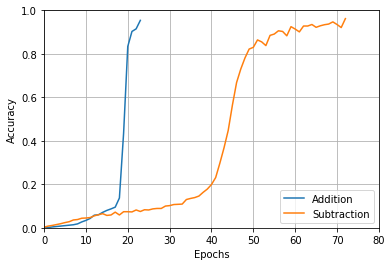

In [28]:
with open('output/sub_pred.csv', newline='') as csvfile:
    rows = csv.reader(csvfile)
    for row in rows:
         sub = [float(j) for j in row]
with open('output/ex1.csv', newline='') as csvfile:
    rows = csv.reader(csvfile)
    for row in rows:
         add = [float(j) for j in row]
axes = plt.gca()
axes.set_xlim([0,80])
axes.set_ylim([0,1])
plt.plot(add, label='Addition')
plt.plot(sub, label='Subtraction')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

## Reference

[從零開始的 Sequence to Sequence](http://zake7749.github.io/2017/09/28/Sequence-to-Sequence-tutorial/)<br>
[如何在長短期記憶(LSTM)網絡中利用TimeDistributed層——python語言](https://kknews.cc/zh-tw/tech/y62kj5k.html)<br>
[如何為LSTM重新構建輸入資料（Keras）](http://toments.com/179540/)<br>
[Understanding Input and Output shapes in LSTM | Keras](https://medium.com/@shivajbd/understanding-input-and-output-shape-in-lstm-keras-c501ee95c65e)<br>
[利用Keras建構LSTM模型，以Stock Prediction 為例 1](https://medium.com/@daniel820710/%E5%88%A9%E7%94%A8keras%E5%BB%BA%E6%A7%8Blstm%E6%A8%A1%E5%9E%8B-%E4%BB%A5stock-prediction-%E7%82%BA%E4%BE%8B-1-67456e0a0b)<br>
[A ten-minute introduction to sequence-to-sequence learning in Keras](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html)<br>
[addition_rnn.py | Github](https://github.com/keras-team/keras/blob/master/examples/addition_rnn.py)<br>
[Many to one and many to many LSTM examples in Keras](https://stackoverflow.com/questions/43034960/many-to-one-and-many-to-many-lstm-examples-in-keras)<br>
[使用 Keras 实现简单的 Sequence to Sequence 模型](http://www.zmonster.me/2016/05/29/sequence_to_sequence_with_keras.html)<br>